In [1]:
import pandas as pd 
import numpy as np 

from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("train.csv")

In [ ]:
# 토픽 모델링 예시(LDA)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['재발방지대책 및 향후조치계획'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf)

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx+1}: ", [terms[i] for i in topic.argsort()[:-11:-1]])


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt

In [7]:
okt = Okt()

# 형태소 분석 및 토큰화 함수
def tokenizer(text):
    tokens = okt.nouns(text)  # 명사만 사용 (필요시 morphs로 변경 가능)
    tokens = [word for word in tokens if len(word) > 1]  # 1글자 이하 제거
    return tokens

# CountVectorizer로 토큰화 수행
vectorizer = CountVectorizer(max_features=1000, tokenizer=tokenizer)
X = vectorizer.fit_transform(df['재발방지대책 및 향후조치계획'])

# LDA 모델 학습
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# 토픽별 상위 단어 출력
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"토픽 #{idx+1}: ", [terms[i] for i in topic.argsort()[:-11:-1]])

c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


토픽 #1:  ['방지', '재발', '대책', '통한', '계획', '조치', '안전교육', '향후', '실시', '작업']
토픽 #2:  ['설치', '작업', '이동', '실시', '자재', '확보', '통로', '조치', '구간', '방지']
토픽 #3:  ['작업', '실시', '교육', '확인', '안전', '착용', '사용', '보호', '위험', '안전교육']
토픽 #4:  ['안전', '작업', '사고', '현장', '조치', '관리', '안전교육', '실시', '공사', '계획']
토픽 #5:  ['안전', '작업', '실시', '교육', '사고', '관리', '안전교육', '현장', '철저', '근로자']


In [8]:
from sentence_transformers import SentenceTransformer

# Embedding Vector 추출에 활용할 모델(jhgan/ko-sbert-sts) 불러오기
model = SentenceTransformer('jhgan/ko-sbert-sts', use_auth_token=False)
embeddings = model.encode(df['재발방지대책 및 향후조치계획'].tolist())

c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sentence_transformers\SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


In [9]:
cos_sim_matrix = cosine_similarity(embeddings)

클러스터 개수=2, 실루엣 점수=0.3999
클러스터 개수=3, 실루엣 점수=0.3683
클러스터 개수=4, 실루엣 점수=0.3458
클러스터 개수=5, 실루엣 점수=0.3290
클러스터 개수=6, 실루엣 점수=0.3220
클러스터 개수=7, 실루엣 점수=0.3096
클러스터 개수=8, 실루엣 점수=0.3033
클러스터 개수=9, 실루엣 점수=0.2805
클러스터 개수=10, 실루엣 점수=0.2697


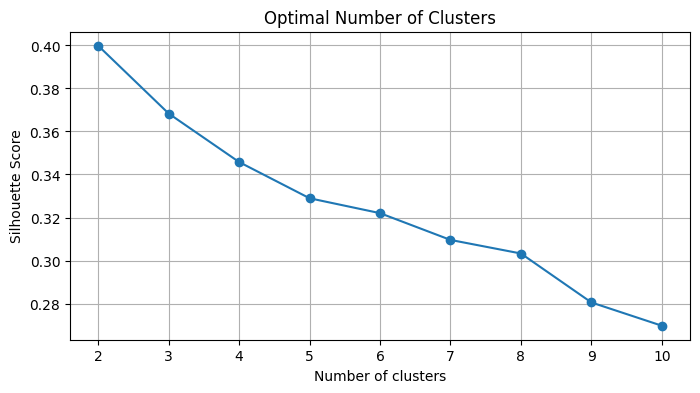

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []

# 2~10개 클러스터까지 테스트하여 최적 클러스터 개수를 찾음
for n_clusters in range(2, 11):
    cluster_model = AgglomerativeClustering(
        n_clusters=n_clusters, metric='cosine', linkage='average'
    )
    labels = cluster_model.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"클러스터 개수={n_clusters}, 실루엣 점수={score:.4f}")

# 결과 그래프 출력
plt.figure(figsize=(8,4))
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid()
plt.show()


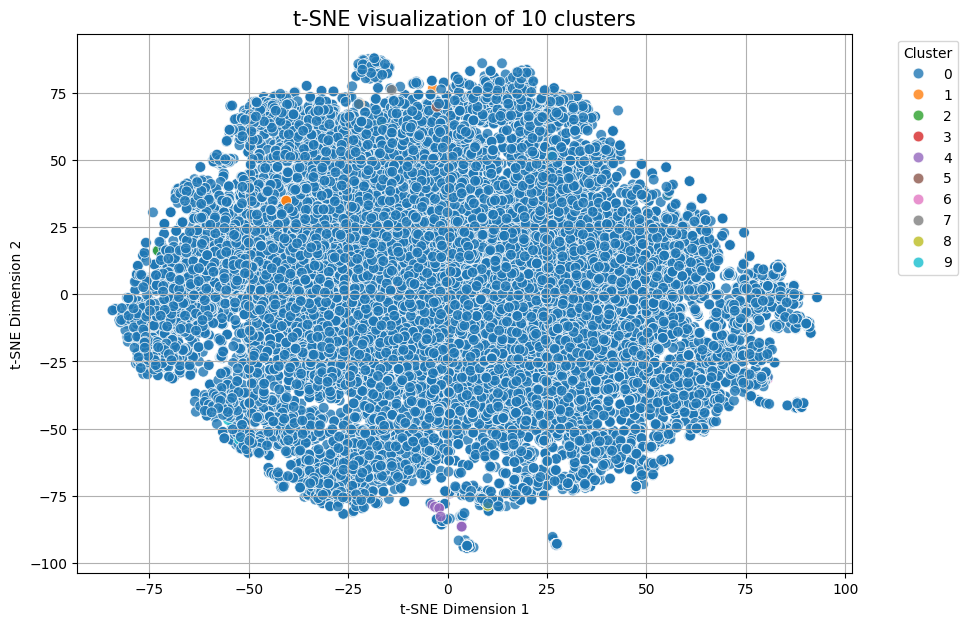

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 앞서 선택한 최적 클러스터 수로 설정 (여기선 예시로 5로 가정)
optimal_clusters = 10

# 클러스터링 다시 수행
cluster_model = AgglomerativeClustering(
    n_clusters=optimal_clusters, metric='cosine', linkage='average'
)
labels = cluster_model.fit_predict(embeddings)

# t-SNE로 차원 축소 (2차원으로 표현)
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, metric='cosine')
tsne_embeddings = tsne_model.fit_transform(embeddings)

# 시각화용 DataFrame 생성
viz_df = pd.DataFrame({
    'x': tsne_embeddings[:, 0],
    'y': tsne_embeddings[:, 1],
    'label': labels,
    'text': df['재발방지대책 및 향후조치계획']
})

# 클러스터 결과 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette=sns.color_palette('tab10', optimal_clusters),
    data=viz_df,
    legend='full',
    s=60,
    alpha=0.8
)

plt.title(f't-SNE visualization of {optimal_clusters} clusters', fontsize=15)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


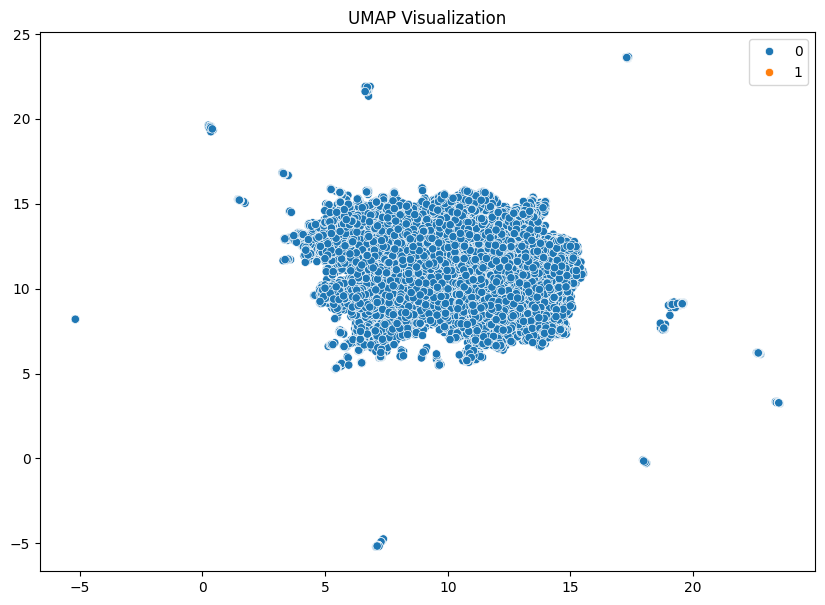

In [13]:
import umap.umap_ as umap
import seaborn as sns

reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_embeddings[:,0], y=umap_embeddings[:,1], hue=labels, palette='tab10')
plt.title('UMAP Visualization')
plt.show()
